In [1]:
#Load packages
library(ggplot2)
library(ISLR)
library(MASS)
library(lmtest)
library(lmtest)
library(sandwich)
library(tree)
library(randomForest)
library(rpart)
library(rpart.plot)
library(Metrics)
library(gbm)
library(xgboost)
library(leaps)
library(corrplot)
library(psych)
library(moments)
library(caret)
library(e1071)


Attaching package: ‘ISLR’

The following object is masked _by_ ‘.GlobalEnv’:

    Auto

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loaded gbm 2.1.4
corrplot 0.84 loaded

Attaching package: ‘psych’

The following object is masked _by_ ‘.GlobalEnv’:

    income

The following object is masked from ‘package:randomForest’:

    outlier

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha

Loading required package: lattice

Attaching package: ‘caret’

The following objects are masked from ‘package:Metrics’:

    precision, recall


Attaching package: ‘e1071’

The following objects are masked from ‘package:moments’:

    kurtosis, moment, skewness



In [2]:
#Load datafiles
load(file = 'data_final.RData')

# Data Wraggling

In [3]:
dim(data_final)

[1] 7033   26

In [4]:
#Fix naming variables
colnames(data_final)[colnames(data_final)=="perc_16+_unempl"] = "perc_16plus_unempl"
colnames(data_final)[colnames(data_final)=="perc_25+_no_school_diploma"] = "perc_25plus_no_school_diploma"

In [5]:
#Drop ZIP variable
data_final = within(data_final, rm('ZIP'))


In [6]:
summary(data_final)

  community_no       PRICE         PROPERTY_TYPE           BEDS       
 Min.   : 1.00   Min.   :  50000   Length:7033        Min.   : 0.000  
 1st Qu.: 8.00   1st Qu.: 232000   Class :character   1st Qu.: 2.000  
 Median :17.00   Median : 400000   Mode  :character   Median : 3.000  
 Mean   :24.53   Mean   : 626091                      Mean   : 2.914  
 3rd Qu.:33.00   3rd Qu.: 682500                      3rd Qu.: 4.000  
 Max.   :77.00   Max.   :8299000                      Max.   :12.000  
     BATHS         SQUARE_FEET      LOCATION           YEAR_BUILT  
 Min.   : 1.000   Min.   :  400   Length:7033        Min.   :1850  
 1st Qu.: 1.500   1st Qu.: 1182   Class :character   1st Qu.:1925  
 Median : 2.000   Median : 1600   Mode  :character   Median :1969  
 Mean   : 2.263   Mean   : 1936                      Mean   :1966  
 3rd Qu.: 3.000   3rd Qu.: 2300                      3rd Qu.:2005  
 Max.   :10.500   Max.   :17769                      Max.   :2020  
     URL               LATI

In [7]:
names(data_final)

[1] "community_no"                  "PRICE"                        
 [3] "PROPERTY_TYPE"                 "BEDS"                         
 [5] "BATHS"                         "SQUARE_FEET"                  
 [7] "LOCATION"                      "YEAR_BUILT"                   
 [9] "URL"                           "LATITUDE"                     
[11] "LONGITUDE"                     "min_dist_cta"                 
[13] "num_cta_1mile"                 "crime_per_1000"               
[15] "life_exp_2010"                 "unemployment"                 
[17] "perc_housing_crowded"          "perc_household_below_poverty" 
[19] "perc_16plus_unempl"            "perc_25plus_no_school_diploma"
[21] "perc_under18_over64"           "income_per_capite"            
[23] "hardship_index"                "percent_level1_school"        
[25] "percent_level2_school"

In [8]:
data_final$community_no = as.factor(data_final$community_no)
data_final$BEDS = as.factor(data_final$BEDS)
data_final$BATHS = as.factor(data_final$BATHS)
data_final$PROPERTY_TYPE = as.factor(data_final$PROPERTY_TYPE)
data_final$LOCATION = as.factor(data_final$LOCATION)
data_final$YEAR_BUILT = as.factor(data_final$YEAR_BUILT)

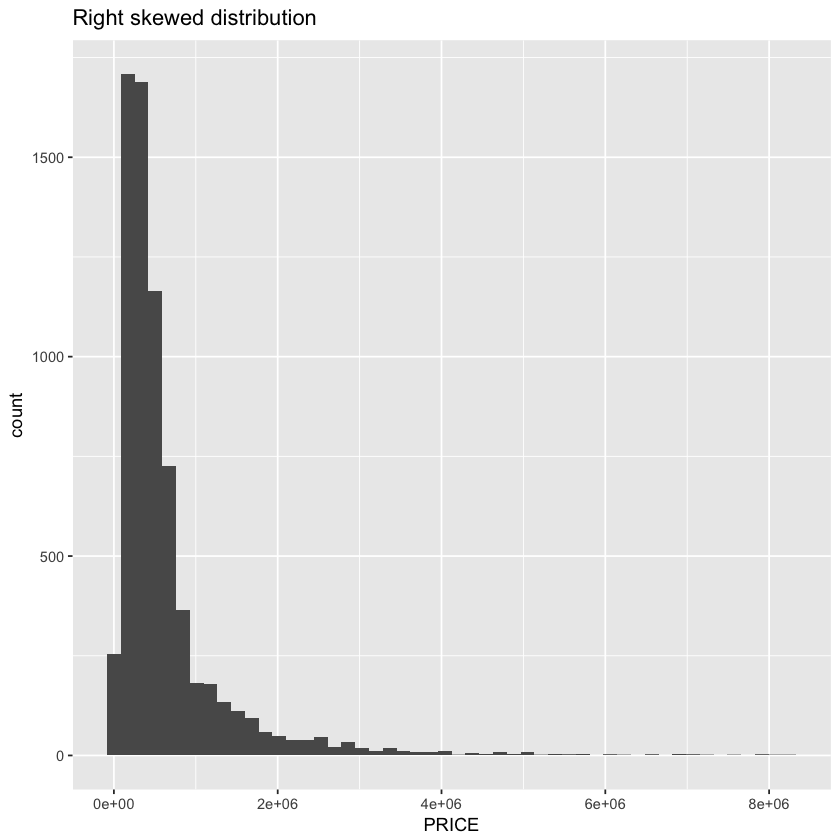

In [9]:
qplot(PRICE, data = data_model_f, bins = 50, main = "Right skewed distribution")

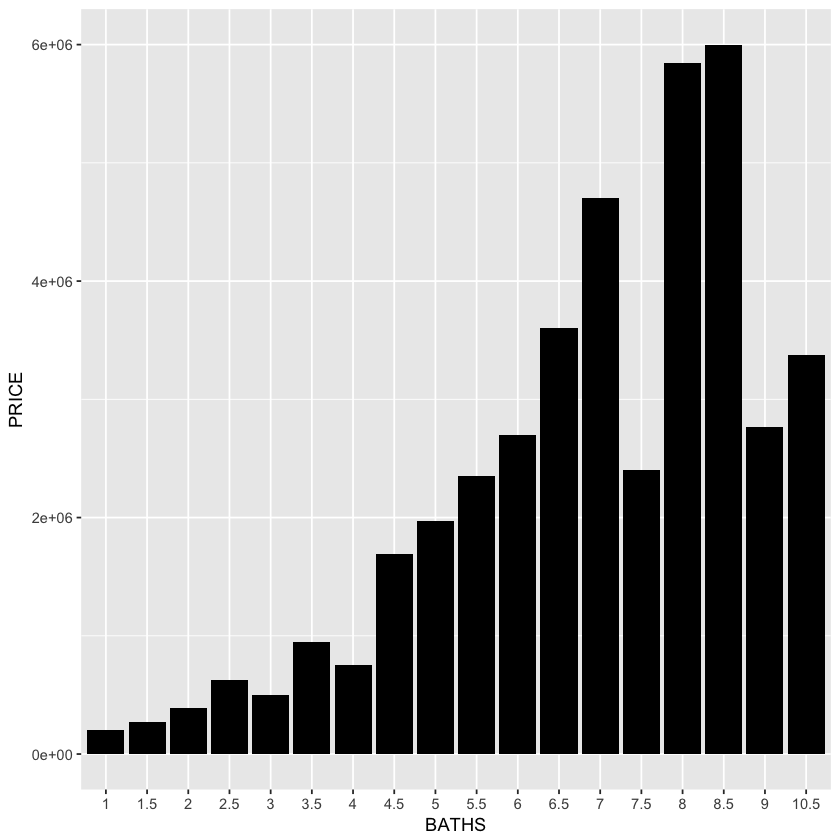

In [10]:
ggplot(data_final, aes(x=BATHS, y=PRICE)) +
        geom_bar(stat='summary', fun.y = "median", fill='black')

In [11]:
numericVars = which(sapply(data_final, is.numeric))
factorVars = which(sapply(data_final, is.factor))
cat('There are', length(numericVars), 'numeric variables, and', length(factorVars), 'categoric variables')

There are 18 numeric variables, and 6 categoric variables

In [12]:
#Geting numeric variables
numericVars = data_final[,numericVars] #index vector numeric variables
numericVarNames = names(numericVars) #saving names vector for use later on
numericVarNames

[1] "PRICE"                         "SQUARE_FEET"                  
 [3] "LATITUDE"                      "LONGITUDE"                    
 [5] "min_dist_cta"                  "num_cta_1mile"                
 [7] "crime_per_1000"                "life_exp_2010"                
 [9] "unemployment"                  "perc_housing_crowded"         
[11] "perc_household_below_poverty"  "perc_16plus_unempl"           
[13] "perc_25plus_no_school_diploma" "perc_under18_over64"          
[15] "income_per_capite"             "hardship_index"               
[17] "percent_level1_school"         "percent_level2_school"

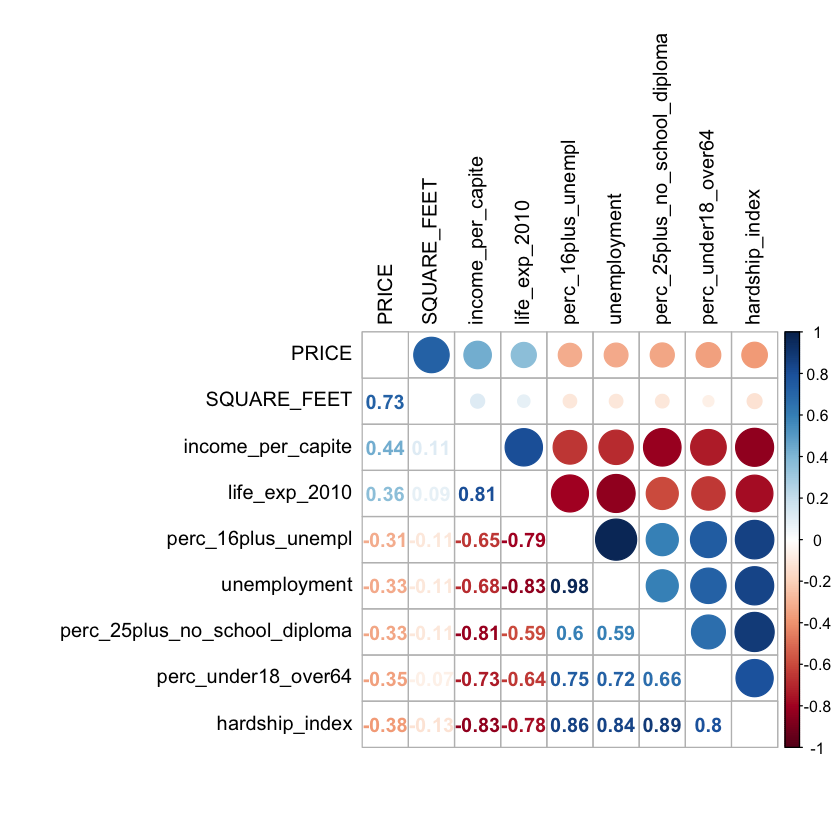

In [13]:
#Check correlation on all numeric variables
cor_numVar = cor(numericVars, use="pairwise.complete.obs") 

#sort on decreasing correlations with PRICE
cor_sorted = as.matrix(sort(cor_numVar[,'PRICE'], decreasing = TRUE))
 #select only high corelations
CorHigh = names(which(apply(cor_sorted, 1, function(x) abs(x)>0.3)))
cor_numVar = cor_numVar[CorHigh, CorHigh]

corrplot.mixed(cor_numVar, tl.col="black", tl.pos = "lt")

## Resolve community variable

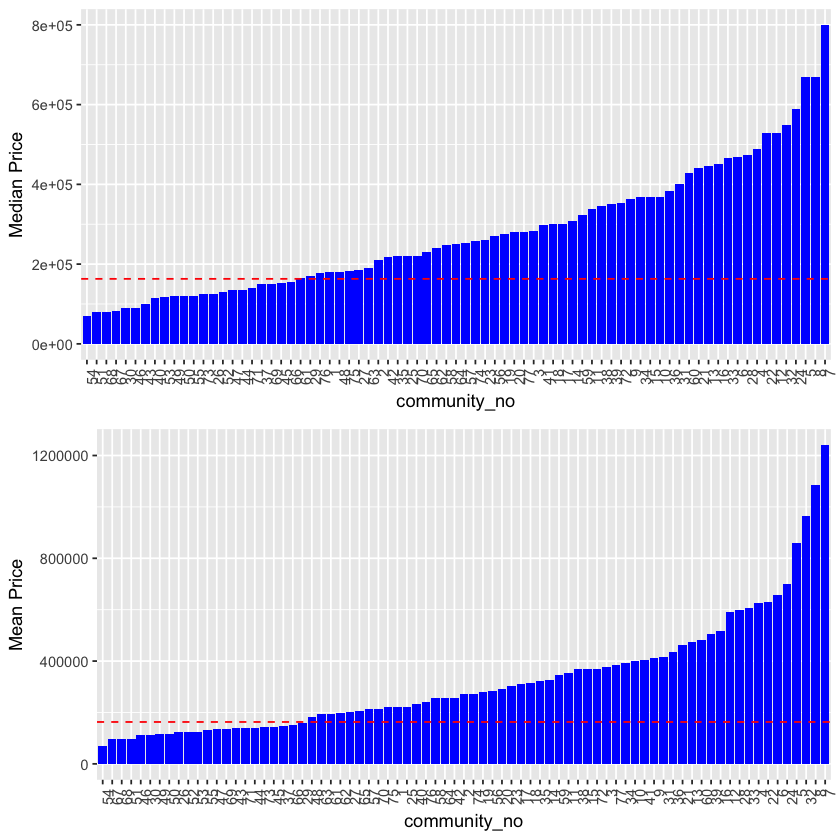

In [14]:
#Resolve community variables (too many categories)
nb1 = ggplot(data_final, aes(x=reorder(community_no, PRICE, FUN=median), y=PRICE)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') + labs(x='community_no', y='Median Price') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice

nb2 = ggplot(data_final, aes(x=reorder(community_no, PRICE, FUN=mean), y=PRICE)) +
        geom_bar(stat='summary', fun.y = "mean", fill='blue') + labs(x='community_no', y="Mean Price") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice

grid.arrange(nb1, nb2)

In [15]:
mean_p_community = aggregate( PRICE ~ community_no, data_final, mean )
mean_p_community[order(-mean_p_community$PRICE),][1:11,]

community_no PRICE    
7  7            1240609.7
8  8            1085969.7
32 32            965808.4
5  5             861406.2
24 24            700320.1
6  6             658857.6
22 22            631683.8
4  4             624669.4
33 33            606307.8
28 28            598055.1
12 12            592278.9

In [16]:
med_p_community = aggregate( PRICE ~ community_no, data_final, median )
med_p_community[order(-med_p_community$PRICE),][1:11,]

community_no PRICE 
7  7            799450
5  5            669000
8  8            669000
24 24           589450
32 32           549900
12 12           529900
22 22           529450
4  4            489000
28 28           474000
6  6            469000
33 33           467000

In [17]:
#Create categories for the extremes
data_final$NeighRich[data_final$community_no %in% c(7,8,32,5,24,6,22,4,33,28,12)] = 2
data_final$NeighRich[!data_final$community_no %in% c(54,67,68,51,46,30,7,8,32,5,24,6,22,4,33,28,12)] = 1
data_final$NeighRich[data_final$community_no %in% c(54,67,68,51,46,30)] = 0

In [18]:
table(data_final$NeighRich, data_final$community_no)

   
       1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1  114  149  150    0    0    0    0    0   48  100   54    0   27   62  106
  2    0    0    0  103  161  512  502 1129    0    0    0   81    0    0    0
   
      16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    7
  1  141  123   28   62   15   64    0   34    0   68    5   14    0    8    0
  2    0    0    0    0    0    0  198    0  478    0    0    0  268    0    0
   
      31   32   33   34   35   36   37   38   39   40   41   42   43   44   45
  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1   29    0    0    9   27   12    3   79   61    6   70   29   59   43   27
  2    0  341  210    0    0    0    0    0    0    0    0    0    0    0    0
   
      46   47   48   49   50   51   

In [19]:
#Factor NeighRich
data_final$NeighRich = as.factor(data_final$NeighRich)

## Resolve YEAR_BUILT variable

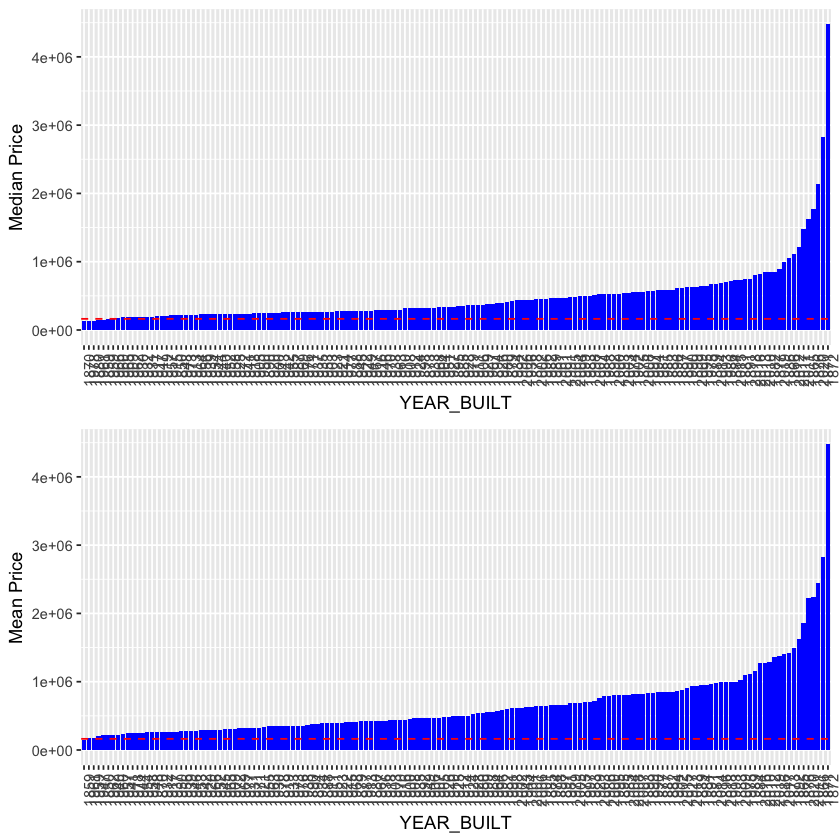

In [20]:
y1 = ggplot(data_final, aes(x=reorder(YEAR_BUILT, PRICE, FUN=median), y=PRICE)) +
        geom_bar(stat='summary', fun.y = "median", fill='blue') + labs(x='YEAR_BUILT', y='Median Price') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice

y2 = ggplot(data_final, aes(x=reorder(YEAR_BUILT, PRICE, FUN=mean), y=PRICE)) +
        geom_bar(stat='summary', fun.y = "mean", fill='blue') + labs(x='YEAR_BUILT', y="Mean Price") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_hline(yintercept=163000, linetype="dashed", color = "red") #dashed line is median SalePrice


grid.arrange(y1, y2)

In [21]:
# Create a new variable: Age of the building
# current (time data was retrieved) - year built
data_final$HouseAge = 2018 - as.numeric(data_final$YEAR_BUILT)


In [22]:
summary(data_final$HouseAge)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1864    1879    1915    1918    1959    2017 

In [23]:
#Drop some variables
data_final2 = within(data_final, rm('community_no', 'LOCATION','YEAR_BUILT','URL'))

In [24]:
names(data_final2)

[1] "PRICE"                         "PROPERTY_TYPE"                
 [3] "BEDS"                          "BATHS"                        
 [5] "SQUARE_FEET"                   "LATITUDE"                     
 [7] "LONGITUDE"                     "min_dist_cta"                 
 [9] "num_cta_1mile"                 "crime_per_1000"               
[11] "life_exp_2010"                 "unemployment"                 
[13] "perc_housing_crowded"          "perc_household_below_poverty" 
[15] "perc_16plus_unempl"            "perc_25plus_no_school_diploma"
[17] "perc_under18_over64"           "income_per_capite"            
[19] "hardship_index"                "percent_level1_school"        
[21] "percent_level2_school"         "NeighRich"                    
[23] "HouseAge"

## Try feature selection with RF

In [444]:
#Use Random forest for feature selection
set.seed(123)
quick_RF = randomForest(PRICE~., data = data_final2, ntree = 100, importance = TRUE)
imp_RF = importance(quick_RF)
imp_DF = data.frame(Variables = row.names(imp_RF), MSE = imp_RF[,1])
imp_DF = imp_DF[order(imp_DF$MSE, decreasing = TRUE),]


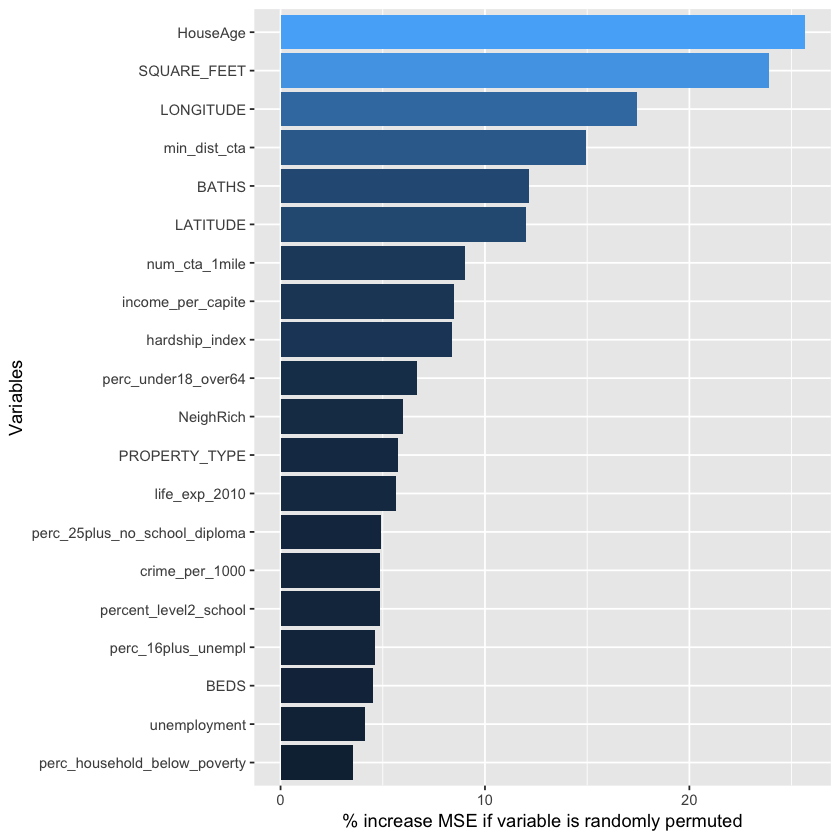

In [445]:
ggplot(imp_DF[1:20,], aes(x=reorder(Variables, MSE), y=MSE, fill = MSE)) +
    geom_bar(stat = 'identity') + coord_flip() +
    labs(x = 'Variables', y= '% increase MSE if variable is randomly permuted') +
    theme(legend.position="none")



## Preprocess variables

In [25]:
numericVars = which(sapply(data_final2, is.numeric))
numericVars = data_final2[,numericVars] #index vector numeric variables
numericVarNames = names(numericVars) #saving names vector for use later on
numericVarNames

[1] "PRICE"                         "SQUARE_FEET"                  
 [3] "LATITUDE"                      "LONGITUDE"                    
 [5] "min_dist_cta"                  "num_cta_1mile"                
 [7] "crime_per_1000"                "life_exp_2010"                
 [9] "unemployment"                  "perc_housing_crowded"         
[11] "perc_household_below_poverty"  "perc_16plus_unempl"           
[13] "perc_25plus_no_school_diploma" "perc_under18_over64"          
[15] "income_per_capite"             "hardship_index"               
[17] "percent_level1_school"         "percent_level2_school"        
[19] "HouseAge"

In [26]:
#Check skewness of numeric predictors:
skewed_stats = c()
var_names = c()
for (i in 1:ncol(numericVars)){
    skewed_stats = append(skewed_stats,abs(skew(numericVars[,i])))
    var_names = append(var_names, numericVarNames[i])
}

skewed_DF = data.frame(cbind(var_names, skewed_stats))
skewed_DF = skewed_DF[order(skewed_DF$skewed_stats, decreasing = TRUE),]

In [27]:
skewed_DF

var_names                     skewed_stats     
1  PRICE                         3.85898998836895 
2  SQUARE_FEET                   2.60484275160139 
6  num_cta_1mile                 2.53123188202575 
10 perc_housing_crowded          2.03562423893446 
9  unemployment                  1.98795278796629 
7  crime_per_1000                1.8421187254943  
12 perc_16plus_unempl            1.79952755435272 
11 perc_household_below_poverty  1.31915888706437 
13 perc_25plus_no_school_diploma 1.26761861079713 
16 hardship_index                1.15867779312922 
3  LATITUDE                      0.974022801298041
4  LONGITUDE                     0.955567897819919
5  min_dist_cta                  0.810533946436691
8  life_exp_2010                 0.663383967853147
17 percent_level1_school         0.421566864957192
15 income_per_capite             0.407685450097589
14 perc_under18_over64           0.369481363141675
19 HouseAge                      0.353464089599639
18 percent_level2_school         0.148985047969173

In [28]:
#Set a new dataset before fixing skewness
data_final3 = data_final2

In [29]:
# Fix numeric predictors
# Use Box-Cox transformation

skewed_vars = sapply(numericVarNames[-1], function(x) {
    skew(data_final3[[x]], na.rm = TRUE)
})

## Keep only features that exceed a threshold 1 for skewness
skewed_vars = skewed_vars[abs(skewed_vars) > 1]

## Transform skewed features with boxcox transformation
for (x in names(skewed_vars)) {
    bc = BoxCoxTrans(data_final3[[x]], lambda = 0.15)
    data_final3[[x]] = predict(bc, data_final3[[x]])
    # combi[[x]] <- log(combi[[x]] + 1)
}

In [30]:
summary(data_final3$SQUARE_FEET)
summary(data_final2$SQUARE_FEET)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.991   7.075   7.378   7.424   7.741   9.785 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    400    1182    1600    1936    2300   17769 

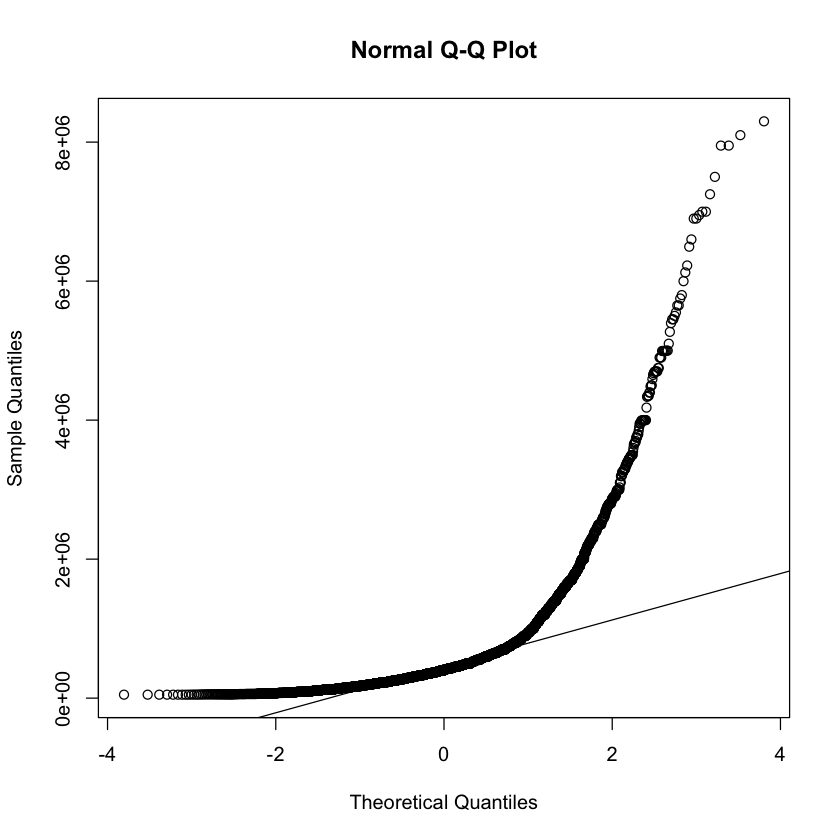

In [31]:
qqnorm(data_final3$PRICE)
qqline(data_final3$PRICE)

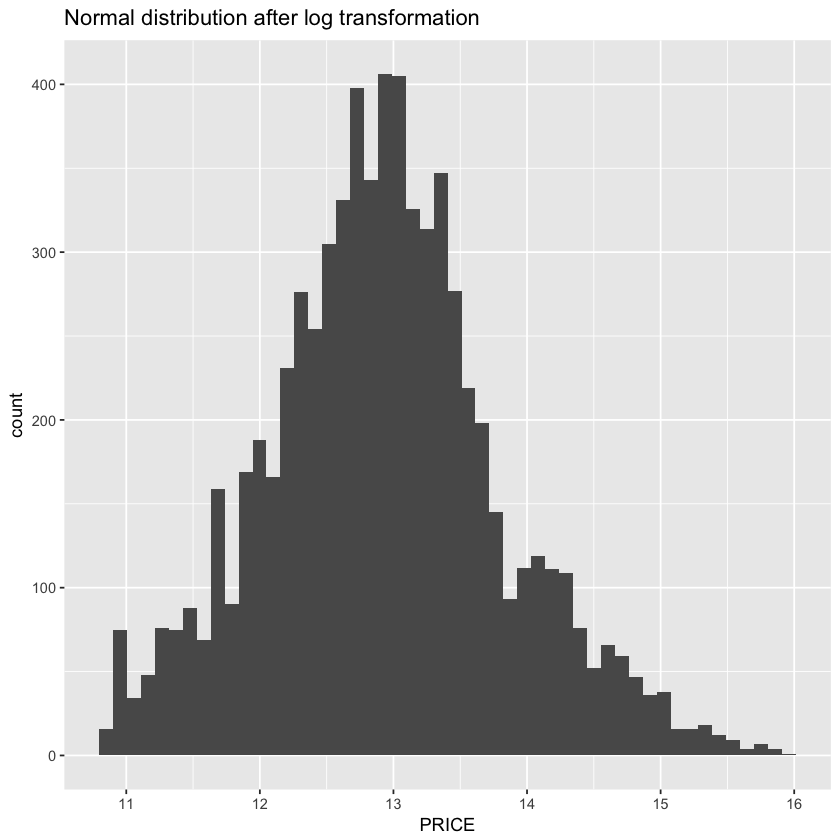

In [32]:
## Log transformation of the target variable
data_final3$PRICE = log(data_final3$PRICE + 1)

## Normal distribution after transformation
qplot(PRICE, data = data_final3, bins = 50, main = "Normal distribution after log transformation")

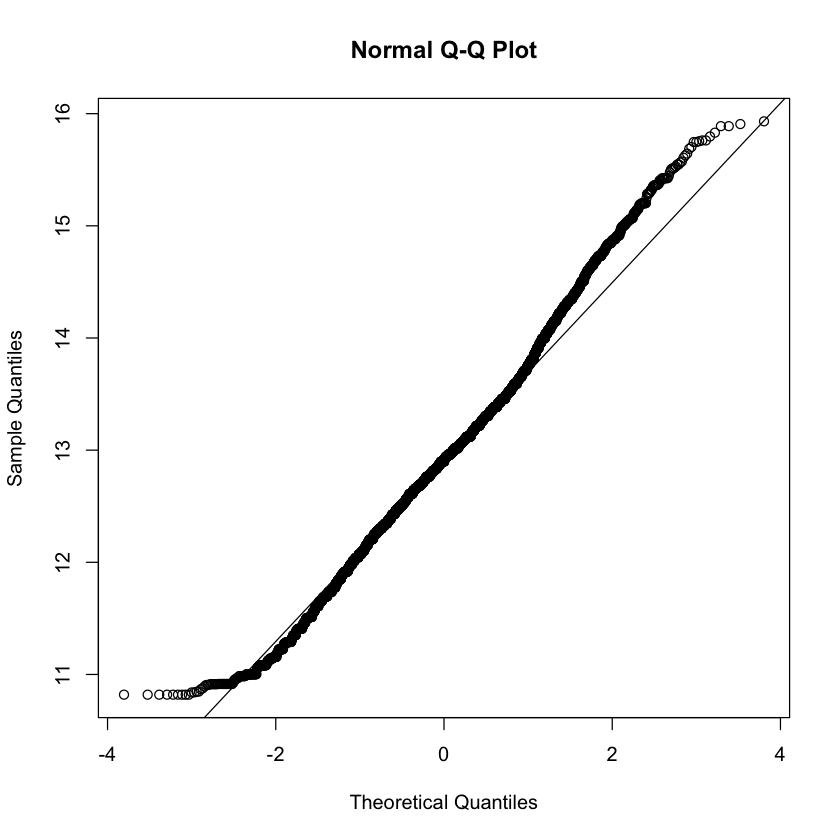

In [33]:
qqnorm(data_final3$PRICE)
qqline(data_final3$PRICE)

### Convert one hot encoding

In [34]:
factorVars = which(sapply(data_final3, is.factor))
dummies = dummyVars(~., data_final3[names(factorVars)])
data_dmy = predict(dummies, data_final3[names(factorVars)])
data_model = cbind(data_final3, data_dmy)

In [35]:
#Drop baseline variables
data_model = within(data_model, rm('BEDS','BATHS','PROPERTY_TYPE','NeighRich'))

dim(data_model)
names(data_model)

[1] 7033   55

[1] "PRICE"                                  
 [2] "SQUARE_FEET"                            
 [3] "LATITUDE"                               
 [4] "LONGITUDE"                              
 [5] "min_dist_cta"                           
 [6] "num_cta_1mile"                          
 [7] "crime_per_1000"                         
 [8] "life_exp_2010"                          
 [9] "unemployment"                           
[10] "perc_housing_crowded"                   
[11] "perc_household_below_poverty"           
[12] "perc_16plus_unempl"                     
[13] "perc_25plus_no_school_diploma"          
[14] "perc_under18_over64"                    
[15] "income_per_capite"                      
[16] "hardship_index"                         
[17] "percent_level1_school"                  
[18] "percent_level2_school"                  
[19] "HouseAge"                               
[20] "PROPERTY_TYPE.Condo/Co-op"              
[21] "PROPERTY_TYPE.Single Family Residential"
[22] "PROPERTY_TYPE.Townhouse"                
[23] "BEDS.0"                                 
[24] "BEDS.1"                                 
[25] "BEDS.2"                                 
[26] "BEDS.3"                                 
[27] "BEDS.4"                                 
[28] "BEDS.5"                                 
[29] "BEDS.6"                                 
[30] "BEDS.7"                                 
[31] "BEDS.8"                                 
[32] "BEDS.9"                                 
[33] "BEDS.10"                                
[34] "BEDS.12"                                
[35] "BATHS.1"                                
[36] "BATHS.1.5"                              
[37] "BATHS.2"                                
[38] "BATHS.2.5"                              
[39] "BATHS.3"                                
[40] "BATHS.3.5"                              
[41] "BATHS.4"                                
[42] "BATHS.4.5"                              
[43] "BATHS.5"                                
[44] "BATHS.5.5"                              
[45] "BATHS.6"                                
[46] "BATHS.6.5"                              
[47] "BATHS.7"                                
[48] "BATHS.7.5"                              
[49] "BATHS.8"                                
[50] "BATHS.8.5"                              
[51] "BATHS.9"                                
[52] "BATHS.10.5"                             
[53] "NeighRich.0"                            
[54] "NeighRich.1"                            
[55] "NeighRich.2"

## Compose Train and Test sets

In [36]:
#Split train set into train and validation set: train 90% and validation 10%
set.seed(123)
train = sample(dim(data_model)[1], dim(data_model)[1]*0.8 )
trainData = data_model[train,]
testData = data_model[-train,]

In [37]:
dim(trainData)
dim(testData)

[1] 5626   55

[1] 1407   55

In [38]:
#Save data
save(data_model, file = 'data/newdata/data_model.RData')
save(trainData, file = 'data/newdata/trainData.RData')
save(testData, file = 'data/newdata/testData.RData')